In [1]:
import os
import sys
import shutil
import glob
import time
import subprocess
import zipfile
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import torchvision.transforms as T
from PIL import Image

def no_op(func):
    return func

torch.jit.script = no_op
torch.jit.script_method = no_op

print(" JIT(TorchScript) 기능을 메모리에서 강제로 껐습니다. (Global alloc 오류 해결)")
# ======================================================
# [핵심] 무한 재귀 방지용 grid_sample 패치 (Mask2Former 필수)
# ======================================================
# 1. 원본 함수 백업
if not hasattr(F, "_original_grid_sample_backup"):
    F._original_grid_sample_backup = F.grid_sample
    print(" 원본 grid_sample 함수 백업 완료.")

def patched_grid_sample(input, grid, mode='bilinear', padding_mode='zeros', align_corners=None):
    # 빈 데이터가 들어올 경우, 충돌 대신 빈 텐서를 반환
    if input.numel() == 0 or grid.numel() == 0:
        if len(input.shape) >= 2:
            N = input.shape[0]
            C = input.shape[1]
            spatial_dims = grid.shape[1:-1]
            output_shape = (N, C) + spatial_dims
            return input.new_zeros(output_shape)

    # 반드시 '백업해둔 원본 함수'를 호출해야 무한 루프에 빠지지 않음
    return F._original_grid_sample_backup(input, grid, mode=mode, padding_mode=padding_mode, align_corners=align_corners)

# 2. 패치 적용
F.grid_sample = patched_grid_sample
print(" grid_sample 패치 적용 완료 (Recursion Safe).")


# ======================================================
# [설정] 윈도우 경로 및 GPU 설정
# ======================================================

# 1. 프로젝트 루트 경로 설정
ROOT_DIR = "C:/Mask2Former"

# 2. 파이썬이 모듈을 찾을 수 있게 경로 추가
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

# 3. 작업 폴더로 이동
os.chdir(ROOT_DIR)
print(f"\n현재 작업 경로: {os.getcwd()}")

# 4. GPU 확인
if torch.cuda.is_available():
    print(f" 사용 가능한 GPU: {torch.cuda.get_device_name(0)}")
    device = "cuda"
else:
    print(" 주의: GPU를 찾을 수 없습니다. CPU로 실행됩니다.")
    device = "cpu"

print(" 환경 설정 및 필수 라이브러리 로드 완료!")

 JIT(TorchScript) 기능을 메모리에서 강제로 껐습니다. (Global alloc 오류 해결)
 원본 grid_sample 함수 백업 완료.
 grid_sample 패치 적용 완료 (Recursion Safe).

현재 작업 경로: C:\Mask2Former
 사용 가능한 GPU: NVIDIA GeForce RTX 4070 SUPER
 환경 설정 및 필수 라이브러리 로드 완료!


In [2]:
import os
import zipfile

# ==========================================
# 2. 경로 및 데이터셋 설정 (윈도우 호환 패치)
# ==========================================

# [수정 1] 경로 역슬래시(\) -> 슬래시(/)로 변경 (윈도우 호환성 해결)
PROJECT_ROOT_PATH = 'C:/Mask2Former'
PROJECT_PARENT_PATH = os.path.dirname(PROJECT_ROOT_PATH)

if PROJECT_PARENT_PATH not in sys.path:
    sys.path.append(PROJECT_PARENT_PATH)

DATASET_FILENAME = "mapping_challenge_final_dataset(5000set).zip"
DATASET_ZIP_PATH = os.path.join(PROJECT_ROOT_PATH, DATASET_FILENAME)
LOCAL_DATA_DIR = "C:/Mask2Former/data" # 데이터 풀릴 곳 명확하게 지정
UNZIPPED_DATA_PATH = os.path.join(LOCAL_DATA_DIR, "mapping_challenge_final_dataset(5000set)")

print(f"Dataset Path: {DATASET_ZIP_PATH}")

if not os.path.exists(DATASET_ZIP_PATH):
    # 혹시 파일이 없으면 에러 대신 경고만 출력 (이미 풀려있을 수도 있으니)
    print(f" 경고: 압축 파일을 찾을 수 없습니다: {DATASET_ZIP_PATH}")
    print("이미 압축이 풀려 있다면 그대로 진행됩니다.")

# [수정 2] 윈도우에는 'unzip' 명령어가 없으므로 파이썬 내장 라이브러리(zipfile) 사용
if not os.path.exists(UNZIPPED_DATA_PATH):
    if os.path.exists(DATASET_ZIP_PATH):
        print("Unzipping dataset... (Python zipfile 이용)")
        os.makedirs(LOCAL_DATA_DIR, exist_ok=True)

        try:
            with zipfile.ZipFile(DATASET_ZIP_PATH, 'r') as zip_ref:
                zip_ref.extractall(LOCAL_DATA_DIR)
            print(" Dataset ready.")
        except Exception as e:
            print(f" 압축 해제 중 오류 발생: {e}")
    else:
        print(" 압축 파일도 없고, 풀린 폴더도 없습니다. 경로를 확인해주세요.")
else:
    print(" Dataset already exists (Skipping unzip).")

Dataset Path: C:/Mask2Former\mapping_challenge_final_dataset(5000set).zip
Unzipping dataset... (Python zipfile 이용)
 Dataset ready.


In [3]:
# ==========================================
# 3. 코드 버그 패치 & 로그 끄기 (윈도우 인코딩 호환 패치)
# ==========================================

# (1) criterion.py 패치
CRITERION_PATH = os.path.join(PROJECT_ROOT_PATH, "matcher_criterion/criterion.py")
criterion_patches = [
    {
        "old": "class_loss = F.cross_entropy(predicted_class.reshape(B*Q, 2), target_class, self.background_ratio, self.background_ratio.to(predicted_class.device))",
        "new": "class_loss = F.cross_entropy(predicted_class.reshape(B*Q, 2), target_class, weight=self.background_ratio.to(predicted_class.device))"
    },
    {
        "old": "target_mask = torch.index_select(target_mask, dim=0, index=t_idx).unsqueeze(1)",
        "new": "target_mask = torch.index_select(target_mask, dim=0, index=t_idx.to(target_mask.device)).unsqueeze(1)"
    }
]

if os.path.exists(CRITERION_PATH):
    # [수정] encoding='utf-8' 추가
    with open(CRITERION_PATH, 'r', encoding='utf-8') as f:
        code = f.read()

    patched = False
    for p in criterion_patches:
        if p["old"] in code:
            code = code.replace(p["old"], p["new"])
            patched = True

    if patched:
        # [수정] 쓸 때도 utf-8로 저장
        with open(CRITERION_PATH, 'w', encoding='utf-8') as f:
            f.write(code)
        print(" 'criterion.py' patched.")

# (2) matcher.py 로그 끄기
MATCHER_PATH = os.path.join(PROJECT_ROOT_PATH, "matcher_criterion/matcher.py")
prints_to_silence = [
    'print("matched가 비어 있습니다.")',
    'print("matched가 비워있습니다.")',
    'print("매칭된 것이 없습니다.")'
]

if os.path.exists(MATCHER_PATH):
    # [수정] encoding='utf-8' 추가
    with open(MATCHER_PATH, 'r', encoding='utf-8') as f:
        code = f.read()

    silenced_count = 0
    for p in prints_to_silence:
        if p in code:
            code = code.replace(p, f"# {p} # Silenced")
            silenced_count += 1

    if silenced_count > 0:
        # [수정] 쓸 때도 utf-8로 저장
        with open(MATCHER_PATH, 'w', encoding='utf-8') as f:
            f.write(code)
        print(f" Silenced {silenced_count} logs in 'matcher.py'.")

In [4]:
# ==========================================
# 4. 모델 및 학습 설정 (Swin-Tiny 복귀 + 512px)
# ==========================================
from fvcore.common.config import CfgNode as _CfgNode
# 경로 문제 해결된 import
try:
    from Mask2Former.helper.helper import ShapeSpec
except ImportError:
    from helper.helper import ShapeSpec

# [설정] Tiny는 가벼우니 배치를 늘려도 됩니다!
BATCH_SIZE = 10   # (Base는 1이었음 -> Tiny는 4 가능)
EPOCHS = 100     # 충분히 학습
LEARNING_RATE = 5e-5
NUM_CLASSES = 1
NUM_QUERIES = 100
DEC_LAYERS = 3
ENC_LAYERS = 3

# 데이터 개수 (10,000장 기준)
TRAIN_SPLIT = 9000
TEST_SPLIT = 1000

input_shape = ShapeSpec(channels=3)

backbone_cfg = _CfgNode()
backbone_cfg.MODEL = _CfgNode()
backbone_cfg.MODEL.SWIN = _CfgNode()
backbone_cfg.MODEL.SWIN.PRETRAIN_IMG_SIZE = 244 # (가중치 원본 크기)
backbone_cfg.MODEL.SWIN.PATCH_SIZE = 4

# [핵심 복구] Swin-Tiny 스펙 (여기가 Base랑 다릅니다!)
backbone_cfg.MODEL.SWIN.EMBED_DIM = 96         # 128 -> 96
backbone_cfg.MODEL.SWIN.DEPTHS = [2, 2, 6, 2]  # [2, 2, 18, 2] -> [2, 2, 6, 2]
backbone_cfg.MODEL.SWIN.NUM_HEADS = [3, 6, 12, 24] # [4, 8, 16, 32] -> [3, 6, 12, 24]

backbone_cfg.MODEL.SWIN.WINDOW_SIZE = 7        # 12 -> 7 (Tiny 기본값)
backbone_cfg.MODEL.SWIN.MLP_RATIO = 4.0
backbone_cfg.MODEL.SWIN.QKV_BIAS = True
backbone_cfg.MODEL.SWIN.QK_SCALE = None
backbone_cfg.MODEL.SWIN.DROP_RATE = 0.0
backbone_cfg.MODEL.SWIN.ATTN_DROP_RATE = 0.0
backbone_cfg.MODEL.SWIN.DROP_PATH_RATE = 0.3
backbone_cfg.MODEL.SWIN.APE = False
backbone_cfg.MODEL.SWIN.PATCH_NORM = True
backbone_cfg.MODEL.SWIN.USE_CHECKPOINT = False # Tiny는 메모리 널널해서 꺼도 됨
backbone_cfg.MODEL.SWIN.OUT_INDICES = (0, 1, 2, 3)
backbone_cfg.MODEL.SWIN.OUT_FEATURES = ["res2", "res3", "res4", "res5"]

pixel_decoder_cfg = _CfgNode()
pixel_decoder_cfg.MODEL = _CfgNode()
pixel_decoder_cfg.MODEL.SEM_SEG_HEAD = _CfgNode()
pixel_decoder_cfg.MODEL.SEM_SEG_HEAD.IN_FEATURES = ["res2", "res3", "res4", "res5"]
pixel_decoder_cfg.MODEL.SEM_SEG_HEAD.CONVS_DIM = 256
pixel_decoder_cfg.MODEL.SEM_SEG_HEAD.MASK_DIM = 256
pixel_decoder_cfg.MODEL.SEM_SEG_HEAD.NORM = "GN"
pixel_decoder_cfg.MODEL.SEM_SEG_HEAD.TRANSFORMER_ENC_LAYERS = ENC_LAYERS
pixel_decoder_cfg.MODEL.MASK_FORMER = _CfgNode()
pixel_decoder_cfg.MODEL.MASK_FORMER.DROPOUT = 0.1
pixel_decoder_cfg.MODEL.MASK_FORMER.NHEADS = 8
pixel_decoder_cfg.MODEL.MASK_FORMER.DIM_FEEDFORWARD = 1024
pixel_decoder_cfg.MODEL.MASK_FORMER.PRE_NORM = False
pixel_decoder_cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = NUM_CLASSES

transformer_decoder_cfg = _CfgNode()
transformer_decoder_cfg.MODEL = _CfgNode()
transformer_decoder_cfg.MODEL.MASK_FORMER = _CfgNode()
transformer_decoder_cfg.MODEL.MASK_FORMER.NHEADS = 8
transformer_decoder_cfg.MODEL.MASK_FORMER.DIM_FEEDFORWARD = 2048
transformer_decoder_cfg.MODEL.MASK_FORMER.DEC_LAYERS = DEC_LAYERS
transformer_decoder_cfg.MODEL.MASK_FORMER.DROPOUT = 0.0
transformer_decoder_cfg.MODEL.MASK_FORMER.NUM_OBJECT_QUERIES = NUM_QUERIES
transformer_decoder_cfg.MODEL.SEM_SEG_HEAD = _CfgNode()
transformer_decoder_cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = NUM_CLASSES

In [5]:
import os
import glob
import random
import torch
import numpy as np
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset
from PIL import Image

# ==========================================
# 5. 데이터셋 클래스 (Resize 최적화 적용)
# ==========================================
class FinalInstanceDataset(Dataset):
    def __init__(self, root_dir, split="train", transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.target_size = (224, 224)

        self.image_dir = self._find_dir(root_dir, 'images')
        self.label_dir = self._find_dir(root_dir, 'labels_dict')

        if self.image_dir:
            all_files = sorted(glob.glob(os.path.join(self.image_dir, "*.pt")))
            total_files = len(all_files)

            # train_split_cfg, test_split_cfg 변수는 외부(이전 셀)에서 가져옴
            train_split_cfg = globals().get('TRAIN_SPLIT', 9000)
            test_split_cfg = globals().get('TEST_SPLIT', 1000)

            if total_files < (train_split_cfg + test_split_cfg):
                split_idx = int(total_files * 0.9)
            else:
                split_idx = train_split_cfg

            if self.split == "train":
                self.image_paths = all_files[:split_idx]
                print(f" [Train] {len(self.image_paths)}장")
            elif self.split == "test":
                end_idx = min(split_idx + test_split_cfg, total_files)
                self.image_paths = all_files[split_idx:end_idx]
                print(f" [Test] {len(self.image_paths)}장")
        else:
            self.image_paths = []

    def _find_dir(self, base, name):
        for root, dirs, files in os.walk(base):
            if name in dirs: return os.path.join(root, name)
        return os.path.join(base, name)

    def __len__(self):
        return len(self.image_paths)

    def transform_data(self, image, mask):
        # [최적화] 이미지가 이미 목표 크기(224x224)라면 Resize 생략
        if image.shape[-2:] == self.target_size:
            return image, mask

        # 크기가 다를 경우에만 안전장치로 Resize 수행
        image = TF.resize(image, self.target_size, interpolation=T.InterpolationMode.BILINEAR)
        mask = TF.resize(mask, self.target_size, interpolation=T.InterpolationMode.NEAREST)
        return image, mask

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]

        try:
            # 1. 데이터 로드
            raw_data = torch.load(image_path, map_location='cpu')

            # 2. 강제 형변환 (Numpy -> Tensor)
            if isinstance(raw_data, np.ndarray):
                image = torch.from_numpy(raw_data)
            elif not isinstance(raw_data, torch.Tensor):
                image = T.functional.to_tensor(raw_data)
            else:
                image = raw_data

            # 3. 차원 순서 교정 (H, W, C) -> (C, H, W)
            if image.ndim == 3 and image.shape[2] == 3 and image.shape[0] != 3:
                image = image.permute(2, 0, 1)
            elif image.ndim == 2:
                image = image.unsqueeze(0)

            # 4. 채널 교정 (1채널 -> 3채널 복사)
            if image.shape[0] == 1:
                image = image.repeat(3, 1, 1)
            elif image.shape[0] > 3:
                image = image[:3, :, :]

            # 5. 값 범위 교정 (0~255 -> 0~1)
            image = image.float() / 255.0

            # --- 라벨 로드 ---
            file_name = os.path.basename(image_path)
            lbl_path = os.path.join(self.label_dir, file_name) if self.label_dir else ""

            img_h, img_w = image.shape[1], image.shape[2]
            mask_tensor = torch.zeros((0, img_h, img_w))
            instance_class = torch.tensor([], dtype=torch.long)

            if os.path.exists(lbl_path):
                try:
                    loaded_label = torch.load(lbl_path, map_location='cpu')
                    if isinstance(loaded_label, dict):
                        if 'mask' in loaded_label: mask_tensor = loaded_label['mask']
                        elif 'masks' in loaded_label: mask_tensor = loaded_label['masks']
                        if 'instance_class' in loaded_label: instance_class = loaded_label['instance_class']
                    elif torch.is_tensor(loaded_label):
                        mask_tensor = loaded_label
                except: pass

            if mask_tensor.ndim == 2: mask_tensor = mask_tensor.unsqueeze(0)
            mask_tensor = (mask_tensor > 0.5).to(torch.uint8)

            # 6. 이미지와 마스크 크기 동기화 (라벨이 이미지보다 작거나 클 경우만 처리)
            if mask_tensor.shape[-2:] != image.shape[-2:] and mask_tensor.shape[0] > 0:
                mask_tensor = T.functional.resize(
                    mask_tensor, image.shape[-2:], interpolation=T.InterpolationMode.NEAREST
                )

            # === Resize (조건부 실행) ===
            image, mask_tensor = self.transform_data(image, mask_tensor)

            # 정규화 (ImageNet Mean/Std)
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            image = (image - mean) / std

            if instance_class.numel() == 0 and mask_tensor.shape[0] > 0:
                instance_class = torch.zeros(mask_tensor.shape[0], dtype=torch.long)

            return image, {'mask': mask_tensor, 'instance_class': instance_class}

        except Exception as e:
            # 에러 발생 시 더미 데이터 반환 (224x224)
            dummy_img = torch.zeros((3, self.target_size[0], self.target_size[1]))
            dummy_mask = torch.zeros((0, self.target_size[0], self.target_size[1]))
            dummy_class = torch.tensor([], dtype=torch.long)
            return dummy_img, {'mask': dummy_mask, 'instance_class': dummy_class}

def training_collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    return torch.stack(images), targets

c:\Users\mgks2\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 Loaded default 'make_mask2former_model'
Running on: cuda
 [Train] 4500장
 [Test] 500장


c:\Users\mgks2\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some model parameters or buffers are not found in the checkpoint:
pixel_decoder.adapter_1.conv.weight
pixel_decoder.adapter_1.norm.{bias, weight}
pixel_decoder.adapter_2.conv.weight
pixel_decoder.adapter_2.norm.{bias, weight}
pixel_decoder.adapter_3.conv.weight
pixel_decoder.adapter_3.norm.{bias, weight}
pixel_decoder.input_proj.conv.{bias, weight}
pixel_decoder.layer_1.conv.weight
pixel_decoder.layer_1.norm.{bias, weight}
pixel_decoder.layer_2.conv.weight
pixel_decoder.layer_2.norm.{bias, weight}
pixel_decoder.layer_3.conv.weight
pixel_decoder.layer_3.norm.{bias, weight}
pixel_decoder.l

 Swin-Base 가중치 로드: C:/Mask2Former/model_final_86143f.pkl


C:\Users\mgks2\AppData\Local\Temp\ipykernel_4840\165184433.py:58: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\mgks2\AppData\Local\Temp\ipykernel_4840\3988635732.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` 


 Swin-Base (224px) Training Start... (100 Epochs)


C:\Mask2Former\matcher_criterion\matcher.py:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
C:\Users\mgks2\AppData\Local\Temp\ipykernel_4840\165184433.py:101: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


   [Ep 1] 신기록 달성 (Loss: 44.5480)
   [Ep 2] 신기록 달성 (Loss: 33.1727)
   [Ep 3] 신기록 달성 (Loss: 30.5848)
   [Ep 4] 신기록 달성 (Loss: 27.9139)
 Ep 5 | Train: 26.6701 | Test: 26.1537 | Time: 128.3s
   [Ep 5] 신기록 달성 (Loss: 26.1537)
   [Ep 6] 신기록 달성 (Loss: 25.2271)
   [Ep 7] 신기록 달성 (Loss: 25.0266)
   [Ep 8] 신기록 달성 (Loss: 23.7301)
   [Ep 9] 신기록 달성 (Loss: 23.4900)
 Ep 10 | Train: 21.4191 | Test: 23.3656 | Time: 129.2s
   [Ep 10] 신기록 달성 (Loss: 23.3656)
   [Ep 11] 신기록 달성 (Loss: 22.6462)
   [Ep 13] 신기록 달성 (Loss: 21.9305)
 Ep 15 | Train: 18.1020 | Test: 21.4590 | Time: 126.2s
   [Ep 15] 신기록 달성 (Loss: 21.4590)
   [Ep 17] 신기록 달성 (Loss: 21.2050)
   [Ep 19] 신기록 달성 (Loss: 20.6865)
 Ep 20 | Train: 15.8358 | Test: 20.7688 | Time: 129.1s
   [Ep 21] 신기록 달성 (Loss: 20.5899)
 Ep 25 | Train: 14.4015 | Test: 20.7126 | Time: 129.0s
   [Ep 26] 신기록 달성 (Loss: 20.3879)
   [Ep 29] 신기록 달성 (Loss: 20.1454)
 Ep 30 | Train: 13.2089 | Test: 20.3808 | Time: 129.4s
   [Ep 34] 신기록 달성 (Loss: 19.8762)
 Ep 35 | Train: 12.3415 | Test: 20

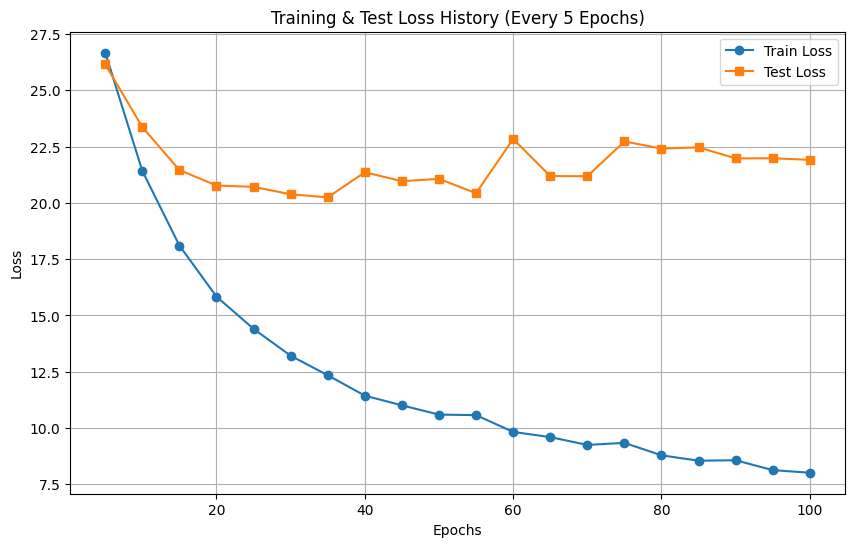

In [6]:
# ==========================================
# 6. 학습 실행 (Loss 기록 및 5 Epoch 주기 저장/시각화)
# ==========================================
import matplotlib.pyplot as plt # 시각화용 라이브러리 추가
from detectron2.checkpoint import DetectionCheckpointer
from torch.cuda.amp import GradScaler, autocast

try:
    from Mask2Former.make_mask2former_model_v2 import Mask2Former
    print(" Loaded 'make_mask2former_model_v2'")
except ImportError:
    from Mask2Former.make_mask2former_model import Mask2Former
    print(" Loaded default 'make_mask2former_model'")

from Mask2Former.matcher_criterion.criterion import criterion

# 4번 셀 설정 따름
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

# 데이터셋 로드 (5번 셀에서 정의한 클래스 사용)
train_ds = FinalInstanceDataset(root_dir=UNZIPPED_DATA_PATH, split="train", transform=None)
test_ds = FinalInstanceDataset(root_dir=UNZIPPED_DATA_PATH, split="test", transform=None)

# Loss 저장을 위한 리스트 선언
train_loss_history = []
test_loss_history = []

if len(train_ds) > 0:
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                              collate_fn=training_collate_fn, num_workers=0)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                             collate_fn=training_collate_fn, num_workers=0)

    model = Mask2Former(
        backbone_cfg=backbone_cfg,
        pixel_decoder_cfg=pixel_decoder_cfg,
        transformer_decoder_cfg=transformer_decoder_cfg,
        input_shape=input_shape
    )
    model.to(device)

    # Swin-Base 가중치 로드
    pretrained_path = "C:/Mask2Former/model_final_86143f.pkl"
    if os.path.exists(pretrained_path):
        print(f" Swin-Base 가중치 로드: {pretrained_path}")
        checkpointer = DetectionCheckpointer(model, save_dir="output")
        checkpointer.resume_or_load(pretrained_path, resume=False)
    else:
        raise FileNotFoundError("가중치 파일 없음")

    loss_fn = criterion(
        oversample_ratio=3.0, important_sample_ratio=0.75,
        class_cost_weight=2.0, mask_cost_weight=5.0, dice_cost_weight=5.0, eos_weigt=0.1
    ).to(device)

    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.05)
    scaler = GradScaler()

    print(f"\n Swin-Base (224px) Training Start... ({EPOCHS} Epochs)")
    best_test_loss = float('inf')

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        start_time = time.time()

        for i, (imgs, tgts) in enumerate(train_loader):
            imgs = imgs.to(device)
            tgt_gpu = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in tgts]

            optimizer.zero_grad()

            with autocast():
                outputs = model(imgs)
                losses = loss_fn(outputs, tgt_gpu)
                final_loss = (losses.get("class_loss", 0) * 2.0 +
                              losses.get("mask_loss", 0) * 5.0 +
                              losses.get("dice_loss", 0) * 5.0)
                for k in losses.keys():
                    if "class_loss_" in k: final_loss += losses[k] *2.0 
                    if "mask_loss_" in k: final_loss += losses[k] * 5.0
                    if "dice_loss_" in k: final_loss += losses[k] * 5.0

            scaler.scale(final_loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += final_loss.item()

        # Epoch 종료 후 평균 Loss 계산
        avg_train_loss = train_loss / len(train_loader)
        
        # Test 실행
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for imgs, tgts in test_loader:
                imgs = imgs.to(device)
                tgt_gpu = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in tgts]
                with autocast():
                    outputs = model(imgs)
                    losses = loss_fn(outputs, tgt_gpu)
                    f_loss = (losses.get("class_loss", 0) * 2.0 +
                              losses.get("mask_loss", 0) * 5.0 +
                              losses.get("dice_loss", 0) * 5.0)
                    for k in losses.keys():
                        if "class_loss_" in k: f_loss += losses[k] * 2.0
                        if "mask_loss_" in k: f_loss += losses[k] * 5.0
                        if "dice_loss_" in k: f_loss += losses[k] * 5.0
                test_loss += f_loss.item()
        
        avg_test_loss = test_loss / len(test_loader)
        epoch_time = time.time() - start_time

        # 5 Epoch마다 리스트에 저장 및 로그 출력
        if (epoch + 1) % 5 == 0:
            train_loss_history.append(avg_train_loss)
            test_loss_history.append(avg_test_loss)
            
            print(f" Ep {epoch+1} | Train: {avg_train_loss:.4f} | Test: {avg_test_loss:.4f} | Time: {epoch_time:.1f}s")
            
            # 체크포인트 저장 (5 Epoch 마다)
            torch.save(model.state_dict(), os.path.join(ROOT_DIR, f"output/mask2former_epoch_{epoch+1}.pth"))

        # Best Loss 갱신 (매 Epoch 체크하여 놓치지 않도록 함)
        if avg_test_loss < best_test_loss:
            best_test_loss = avg_test_loss
            torch.save(model.state_dict(), os.path.join(ROOT_DIR, "output/mask2former_best.pth"))
            # Best 갱신 로그는 중요하므로 매번 출력
            print(f"   [Ep {epoch+1}] 신기록 달성 (Loss: {best_test_loss:.4f})")

    print(" 학습 완료!")
    torch.save(model.state_dict(), os.path.join(ROOT_DIR, "output/mask2former_final.pth"))

    plt.figure(figsize=(10, 6))
    
    # X축: 5, 10, 15... 형태로 설정
    epochs_x = range(5, EPOCHS + 1, 5)
    
    if len(epochs_x) != len(train_loss_history):
        epochs_x = range(5, 5 * len(train_loss_history) + 1, 5)

    plt.plot(epochs_x, train_loss_history, label='Train Loss', marker='o')
    plt.plot(epochs_x, test_loss_history, label='Test Loss', marker='s')
    
    plt.title('Training & Test Loss History (Every 5 Epochs)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print(" 데이터셋 없음")


 [Part 1] Test Dataset에서 5장을 뽑아 정밀 검사를 진행합니다...


C:\Users\mgks2\AppData\Local\Temp\ipykernel_4840\3988635732.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw_data = torch.load(image_path, map_location='cpu')
C:\Use

 5개 샘플 평균 IoU: 76.08%


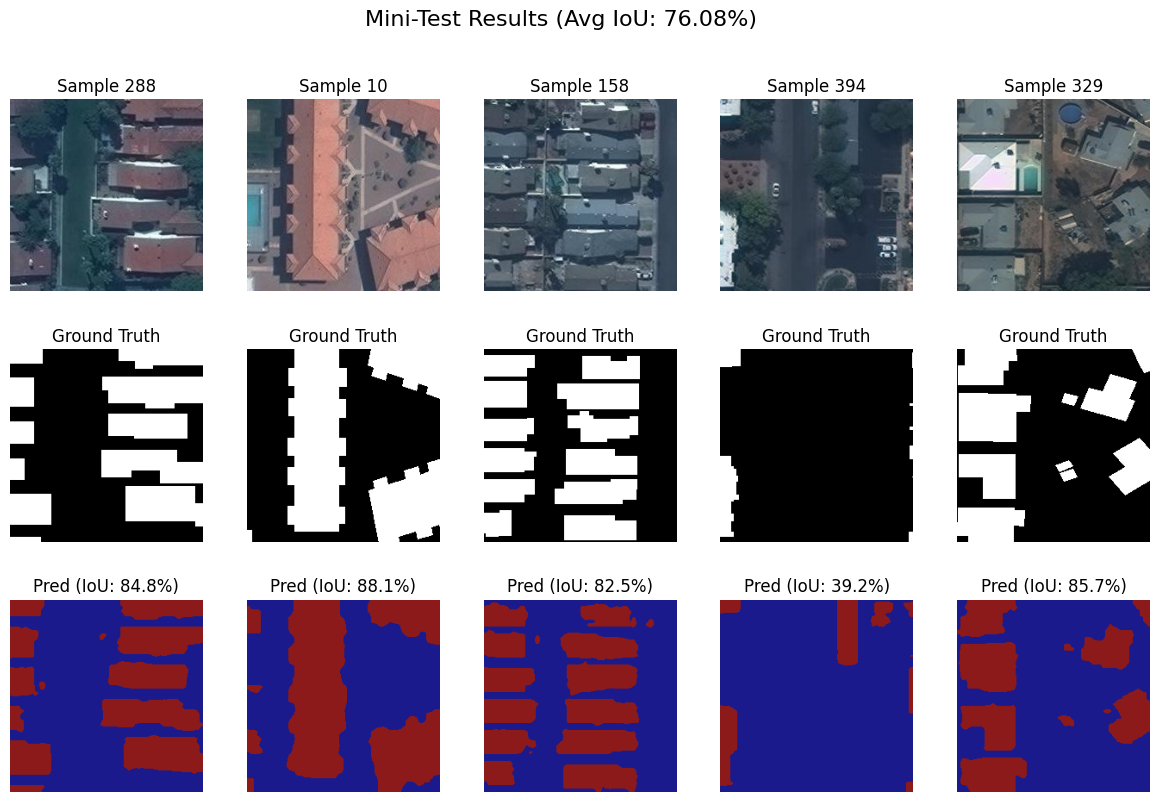

In [7]:
import random
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# ==============================================================
# 9. 모델 성능 검증 (Test Dataset 5장 샘플링 - 최적화 버전)
# ==============================================================

def denormalize(tensor):
    """정규화된 텐서를 시각화를 위해 원래 색상으로 복구"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(tensor.device)
    return tensor * std + mean

# 전역 변수 초기화 (10번 셀 전달용)
global_mini_test_results = []

# 데이터셋이 로드되어 있는지 확인
if 'test_ds' in globals() and len(test_ds) > 0:
    print(f"\n [Part 1] Test Dataset에서 5장을 뽑아 정밀 검사를 진행합니다...")
    
    model.eval()
    
    # 랜덤 샘플링 (5개)
    indices = random.sample(range(len(test_ds)), 5)
    
    # 시각화 설정
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))
    plt.subplots_adjust(wspace=0.1, hspace=0.3)
    
    total_iou = 0
    
    for i, idx in enumerate(indices):
        image, target = test_ds[idx]
        gt_mask = target['mask'].to(device) # (N, H, W) or (H, W)
        
        # -----------------------------------------------------------
        # [핵심 수정] Shape Mismatch 오류 방지 코드
        # 정답지(GT)가 여러 채널(건물 여러 개)일 경우 -> 하나로 병합
        # -----------------------------------------------------------
        if gt_mask.ndim == 3:
            if gt_mask.shape[0] > 1:
                # 채널이 여러 개면 Max 연산으로 병합 (0 or 1)
                gt_mask, _ = gt_mask.max(dim=0)
            else:
                # 채널이 1개면 차원 축소
                gt_mask = gt_mask.squeeze(0)
        # 이제 gt_mask는 무조건 (H, W) 형태가 됨
        # -----------------------------------------------------------

        img_input = image.unsqueeze(0).to(device) # (1, 3, H, W)
        
        with torch.no_grad():
            outputs = model(img_input)
            
            pred_logits = outputs["predicted_class"]
            pred_masks = outputs["predicted_mask"]
            
            pred_probs = F.softmax(pred_logits, dim=-1)
            mask_probs = pred_masks.sigmoid()
            
            # Semantic Segmentation 변환
            sem_seg = torch.einsum("bqc,bqhw->bchw", pred_probs[:, :, :-1], mask_probs)
            
            # 크기 보정 (224x224)
            if sem_seg.shape[-2:] != gt_mask.shape[-2:]:
                sem_seg = F.interpolate(sem_seg, size=gt_mask.shape[-2:], mode="bilinear", align_corners=False)
            
            pred_final = (sem_seg > 0.5).float().squeeze()
            if pred_final.ndim == 3: pred_final = pred_final[0]

        # IoU 계산
        gt_flat = gt_mask.view(-1).float()
        pred_flat = pred_final.view(-1).float()
        
        intersection = (pred_flat * gt_flat).sum().item()
        union = (pred_flat + gt_flat).sum().item() - intersection
        iou = (intersection / union * 100) if union > 0 else 0.0
        total_iou += iou

        # 데이터 저장 (10번 셀용)
        vis_pred = pred_final.cpu().numpy()
        global_mini_test_results.append({
            'id': idx,
            'pred': vis_pred,
            'iou': iou
        })
        
        # --- 시각화 ---
        # 1. 원본 이미지
        vis_img = denormalize(image.to(device)).cpu().permute(1, 2, 0).numpy()
        vis_img = np.clip(vis_img, 0, 1)
        
        # 2. 정답 마스크 (GT)
        vis_gt = gt_mask.cpu().numpy() # 이미 위에서 차원 축소됨
        
        axes[0, i].imshow(vis_img)
        axes[0, i].set_title(f"Sample {idx}")
        axes[0, i].axis('off')
        
        axes[1, i].imshow(vis_gt, cmap='gray')
        axes[1, i].set_title("Ground Truth")
        axes[1, i].axis('off')
        
        axes[2, i].imshow(vis_pred, cmap='jet', alpha=0.9)
        axes[2, i].set_title(f"Pred (IoU: {iou:.1f}%)")
        axes[2, i].axis('off')

    avg_iou = total_iou / 5
    print(f" 5개 샘플 평균 IoU: {avg_iou:.2f}%")
    plt.suptitle(f"Mini-Test Results (Avg IoU: {avg_iou:.2f}%)", fontsize=16)
    plt.show()

else:
    print(" test_ds가 정의되지 않았습니다. 5, 6번 셀을 먼저 실행하세요.")

 9번 셀에서 생성된 5개의 샘플을 벡터화합니다.

[1/5] Sample ID 288 (IoU: 84.76%) 처리 중...


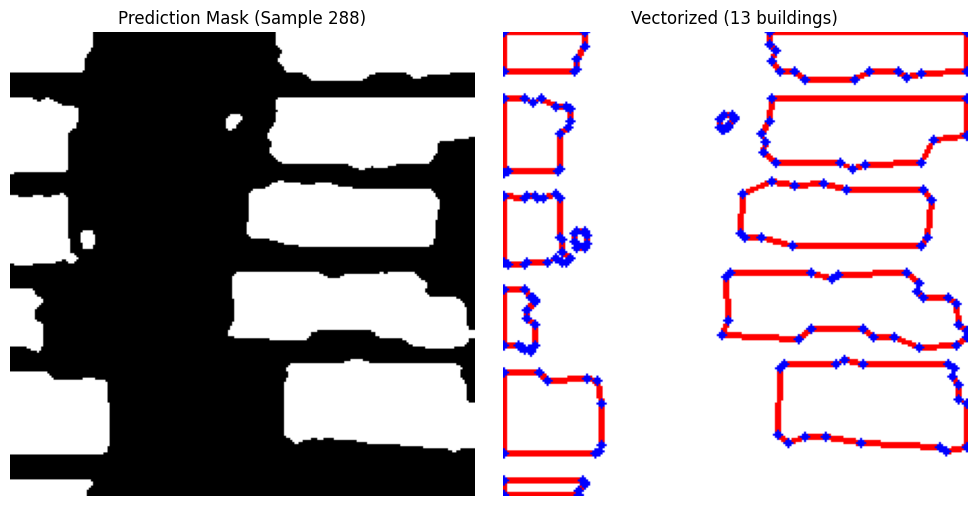

   ㄴ 추출된 건물 수: 13개
--------------------------------------------------
[2/5] Sample ID 10 (IoU: 88.13%) 처리 중...


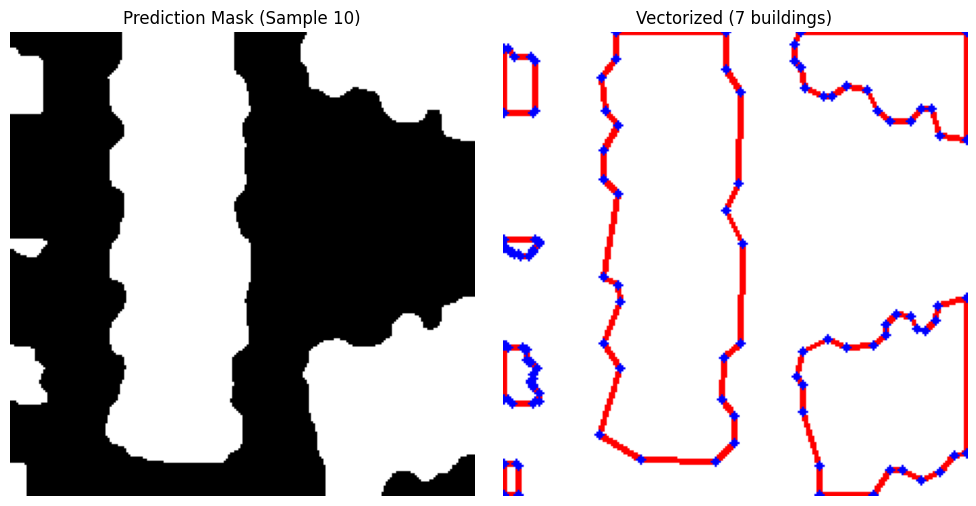

   ㄴ 추출된 건물 수: 7개
--------------------------------------------------
[3/5] Sample ID 158 (IoU: 82.50%) 처리 중...


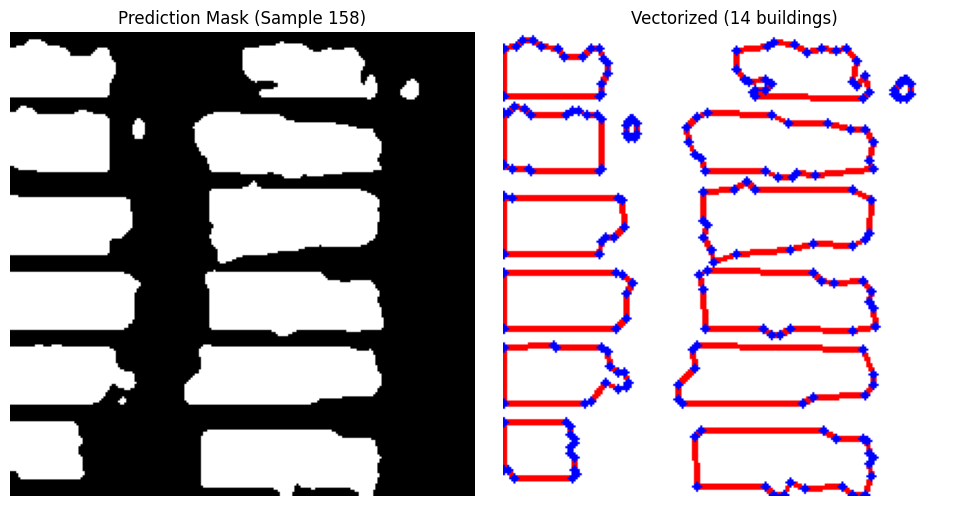

   ㄴ 추출된 건물 수: 14개
--------------------------------------------------
[4/5] Sample ID 394 (IoU: 39.25%) 처리 중...


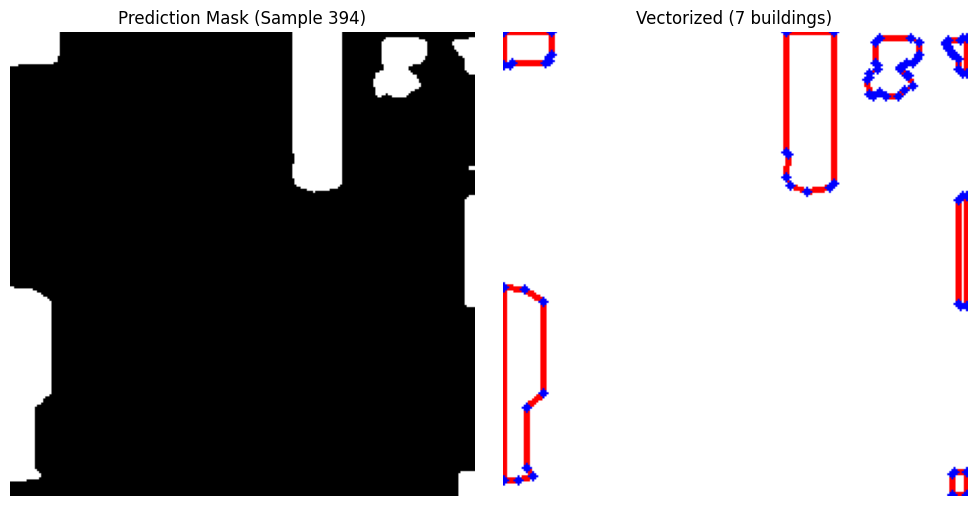

   ㄴ 추출된 건물 수: 7개
--------------------------------------------------
[5/5] Sample ID 329 (IoU: 85.75%) 처리 중...


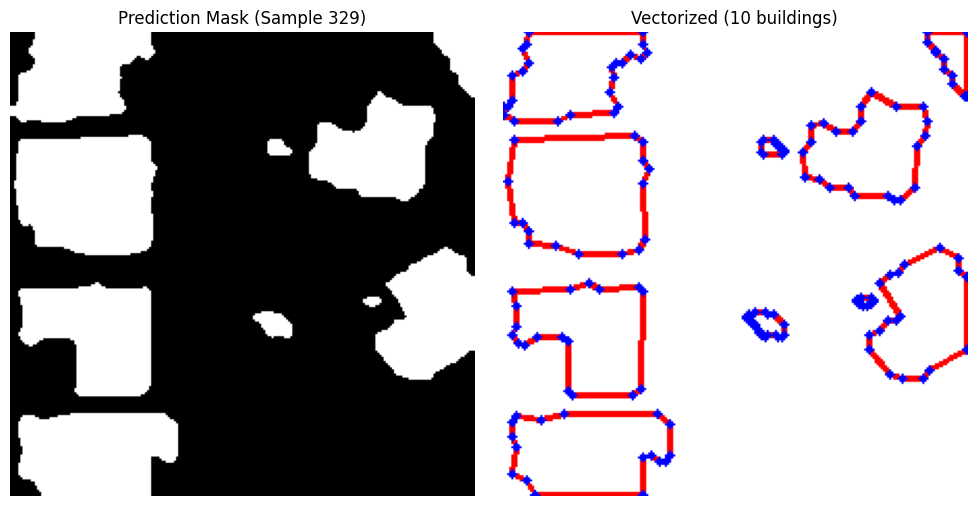

   ㄴ 추출된 건물 수: 10개
--------------------------------------------------
 모든 샘플의 벡터화가 완료되었습니다.


In [8]:
import cv2

# -------------------------------------------------------
# 10. 벡터화 (Test 샘플 5개 대상)
# -------------------------------------------------------

if 'global_mini_test_results' not in globals() or not global_mini_test_results:
    print(" 9번 셀을 먼저 실행해서 테스트 데이터를 생성해주세요.")
else:
    print(f" 9번 셀에서 생성된 {len(global_mini_test_results)}개의 샘플을 벡터화합니다.\n")

    for idx, sample in enumerate(global_mini_test_results):
        print(f"[{idx+1}/5] Sample ID {sample['id']} (IoU: {sample['iou']:.2f}%) 처리 중...")

        # 1. 예측 마스크 가져오기 (0.0 ~ 1.0 -> 0 ~ 255 변환)
        pred_mask = sample['pred']
        binary_img = (pred_mask * 255).astype(np.uint8)

        # 2. 외곽선 검출 (OpenCV)
        contours, _ = cv2.findContours(
            binary_img,
            cv2.RETR_EXTERNAL,       # 가장 바깥쪽 라인만
            cv2.CHAIN_APPROX_SIMPLE  # 점 좌표 최소화
        )

        # 시각화용 이미지 (흰 배경)
        h, w = binary_img.shape
        vector_canvas = np.ones((h, w, 3), dtype=np.uint8) * 255  # 흰색 배경
        
        # 3. 벡터화 (Polygon Approximation)
        building_count = 0
        
        for contour in contours:
            # 면적이 너무 작은 노이즈 제거
            area = cv2.contourArea(contour)
            if area < 10: 
                continue

            # 단순화 (epsilon 조절: 숫자가 클수록 더 각지게, 작을수록 더 상세하게)
            epsilon = 0.005 * cv2.arcLength(contour, True)
            approx_poly = cv2.approxPolyDP(contour, epsilon, True)
            
            # 그리기 (빨간색 선, 두께 2)
            cv2.drawContours(vector_canvas, [approx_poly], -1, (255, 0, 0), 2)
            building_count += 1
            
            # 꼭짓점 찍기 (파란색 점)
            for point in approx_poly:
                cv2.circle(vector_canvas, tuple(point[0]), 2, (0, 0, 255), -1)

        # 4. 결과 시각화 (원본 예측 마스크 vs 벡터화 결과)
        plt.figure(figsize=(10, 5))
        
        # 왼쪽: 모델 예측 마스크
        plt.subplot(1, 2, 1)
        plt.imshow(binary_img, cmap='gray')
        plt.title(f"Prediction Mask (Sample {sample['id']})")
        plt.axis('off')
        
        # 오른쪽: 벡터화 결과
        plt.subplot(1, 2, 2)
        plt.imshow(vector_canvas)
        plt.title(f"Vectorized ({building_count} buildings)")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"   ㄴ 추출된 건물 수: {building_count}개")
        print("-" * 50)
    
    print(" 모든 샘플의 벡터화가 완료되었습니다.")